# Quality Detector

In this script I will create toy CNN that is supposed to detect whether the input image is of a good quality or has artefacts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

## Data Preprocessing

I will start by loading two of the images in. Then I will select from the originals each only one. Aftwards, I will select the 500 images in good and bad quality from the two image and create the classification label for it.

In [2]:
P3_X = np.load('/home/cloud/MRT_Data/unziped/out/P3_X.npy')
P3_Y = np.load('/home/cloud/MRT_Data/unziped/out/P3_Y.npy')
P14_X = np.load('/home/cloud/MRT_Data/unziped/out/P14_X.npy')
P14_Y = np.load('/home/cloud/MRT_Data/unziped/out/P14_Y.npy')

#### Select images from Y only once
To match the number of distorted images in X, the images in Y are each repeated five times subsequently. To get unique images I will only select the first once.

In [3]:
P3_Y = P3_Y[[i for i in range(0,P3_Y.shape[0],5)],:,:,:]

In [4]:
P14_Y = P14_Y[[i for i in range(0,P14_Y.shape[0],5)],:,:,:]

For the distorted pictures saved in P3_X and P14_X I will select on of the five distorted images randomly.

In [5]:
P3_X = P3_X[[i + np.random.randint(0,4) for i in range(0,P3_X.shape[0],5)], :, :,:]

In [6]:
P14_X = P14_X[[i + np.random.randint(0,4) for i in range(0,P14_X.shape[0],5)], :, :,:]

Combine all images and create class vector

In [7]:
shape_x = (4 * P3_X.shape[0],) + P3_X.shape[1:4]

In [8]:
X = np.empty(shape_x,dtype='uint32')
X[0:811,:,:,:] = P3_Y
X[811:1622,:,:,:] = P14_Y
X[1622:2433,:,:,:] = P3_X
X[2433:3244,:,:,:] = P14_X

 Normalize data

In [9]:
X = X / 255

In [10]:
X = X.astype('float32')

In [11]:
Y = np.array([1] * 1622 + [0] * 1622 , dtype='int32')

Shuffle both arrays randomly!

In [12]:
shuffle_index = np.random.choice(range(0,Y.shape[0]), size = Y.shape[0], replace = False)

In [13]:
X = X[shuffle_index,:,:,:]

In [14]:
Y = Y[shuffle_index,]

clean up the mess

In [15]:
del P3_X, P3_Y, P14_X, P14_Y

In [16]:
gc.collect()

7

# Create train and test and validation set

In [18]:
X_train = X[1:2270, :,:,:]
X_eval = X[2270:3244,:,:,:]

Y_train = Y[1:2270,]
Y_eval = Y[2270:3244,]

# Create and train CNN

Create the CNN model

In [26]:
def cnn_model_fn(features, labels, mode):
    
    # Input Layer
    input_layer = features['x']
    
    # Convolutional layer #1
    conv1 = tf.layers.conv2d(
        inputs = input_layer,
        filters = 64,
        kernel_size = [5, 5],
        padding = "same",
        activation= tf.nn.relu)
    
    # Pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size=[2,2], strides = 2)
    
    # Convolutional layer #2
    conv2 = tf.layers.conv2d(
        inputs = pool1,
        filters = 128,
        kernel_size = [5, 5],
        padding = "same",
        activation = tf.nn.relu)
    
    # Pool layer 2 
    pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size=[2,2], strides = 2)
    
    # Convolutional layer 3
    conv3 = tf.layers.conv2d(
        inputs = pool2,
        filters = 128,
        kernel_size = [5, 5],
        padding = "same",
        activation = tf.nn.relu)
    
    # Pool layer 3
    pool3 = tf.layers.max_pooling2d(inputs = conv3, pool_size=[2,2], strides = 2)
    
    # Convolutional layer 4
    conv4 = tf.layers.conv2d(
        inputs = pool3,
        filters = 128,
        kernel_size = [5, 5],
        padding = "same",
        activation = tf.nn.relu)
    
    # Pool layer 4
    pool4 = tf.layers.max_pooling2d(inputs = conv4, pool_size=[2,2], strides = 2)
    
    # Dense Layer
    pool4flat = tf.reshape(pool4, [-1, 16 *  16 * 128])
    dense = tf.layers.dense(inputs = pool4flat, units = 1024, activation = tf.nn.relu)
    dropout = tf.layers.dropout(inputs = dense, rate = 0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logit layer
    logits = tf.layers.dense(inputs = dropout, units = 2)
    
  
    # Calculate predictions
    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions=predictions)
    
    # Calculate Loss (for both Train and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels, logits = logits)

    # Configure the Training OP (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.RMSPropOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(loss = loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
    # Add evaluation metrics
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
    

Load train and test data

In [27]:
train_data = X_train
train_labels = Y_train
eval_data = X_eval
eval_labels = Y_eval

Create the estimator

In [32]:
noise_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/home/cloud/Training/noise_classifier")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/home/cloud/Training/noise_classifier', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f115e6eb9e8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Set Up a Logging Hook

In [33]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

Train the model

In [34]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [ ]:
noise_classifier.train(
    input_fn=train_input_fn,
    steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/cloud/Training/noise_classifier/model.ckpt.
INFO:tensorflow:loss = 0.69613415, step = 1
INFO:tensorflow:Saving checkpoints for 8 into /home/cloud/Training/noise_classifier/model.ckpt.
INFO:tensorflow:Saving checkpoints for 16 into /home/cloud/Training/noise_classifier/model.ckpt.
INFO:tensorflow:Saving checkpoints for 24 into /home/cloud/Training/noise_classifier/model.ckpt.
INFO:tensorflow:Saving checkpoints for 32 into /home/cloud/Training/noise_classifier/model.ckpt.
INFO:tensorflow:Saving checkpoints for 40 into /home/cloud/Training/noise_classifier/model.ckpt.


## Evaluate the model

In [37]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)b
eval_results = noise_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-08-11:45:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/cloud/Training/noise_classifier/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-08-11:48:37
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.98049283, global_step = 1000, loss = 0.03777454
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /home/cloud/Training/noise_classifier/model.ckpt-1000
{'accuracy': 0.98049283, 'loss': 0.03777454, 'global_step': 1000}


Make predictions

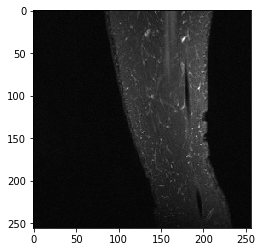

In [132]:
plt.imshow(eval_data[340,:,:,:])

In [133]:
eval_labels[340]

1

This is an original image. What does our network predict?

In [106]:
# Evaluate the model and print results
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
predict_results = noise_classifier.predict(input_fn=predict_input_fn)
predict_results = list(predict_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/cloud/Training/noise_classifier/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


The first dictionary is the image shown above. Although I cannot see much in the picture the network is 99.8% sure that it is original!

In [111]:
predict_results[0]['classes']

1

In [112]:
iter = 0
position = []
true_class = eval_labels
pred_class = []
prob_0 = []
prob_1 = []


for dictio in predict_results:
    position.append(iter)
    pred_class.append(dictio['classes'])
    prob_0.append(dictio['probabilities'][0])
    prob_1.append(dictio['probabilities'][1])
    iter += 1

In [113]:
predictions = pd.DataFrame({'position': position, 'True_Class': true_class, 'Pred_class': pred_class, 'prob_0': prob_0, 'prob_1': prob_1})

In [116]:
predictions[predictions.True_Class != predictions.Pred_class]

,position,True_Class,Pred_class,prob_0,prob_1
19,19,0,1,0.247496,0.752504
105,105,0,1,0.234548,0.765452
139,139,1,0,0.658752,0.341248
286,286,0,1,0.325694,0.674306
297,297,0,1,0.209704,0.790296
340,340,1,0,0.841863,0.158137
348,348,0,1,0.193344,0.806656
352,352,0,1,0.430999,0.569001
408,408,0,1,0.115804,0.884196
422,422,0,1,0.427883,0.572117
